In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(6280, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6280)              12867720  
Total params: 36,455,432
Trainable params: 36,402,312
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group6_set_224/set_224/train/'
valid_data_dir = '../datasets/group6_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 176320 images belonging to 6280 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 43960 images belonging to 6280 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group6_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

6280
{0: '100006', 1: '10005', 2: '100093', 3: '100168', 4: '100175', 5: '100212', 6: '100215', 7: '100325', 8: '100329', 9: '100367', 10: '100513', 11: '100531', 12: '100556', 13: '100586', 14: '100624', 15: '100632', 16: '100635', 17: '100646', 18: '100713', 19: '100742', 20: '100777', 21: '10086', 22: '10092', 23: '100928', 24: '100950', 25: '100985', 26: '101027', 27: '10104', 28: '101081', 29: '101125', 30: '101142', 31: '101148', 32: '101179', 33: '101180', 34: '1012', 35: '101275', 36: '101277', 37: '10136', 38: '101377', 39: '101383', 40: '101431', 41: '101448', 42: '101471', 43: '101501', 44: '101553', 45: '101555', 46: '101609', 47: '101645', 48: '101702', 49: '101715', 50: '101730', 51: '101750', 52: '101776', 53: '101785', 54: '101798', 55: '101799', 56: '101830', 57: '101842', 58: '101898', 59: '101903', 60: '10192', 61: '101996', 62: '102080', 63: '102140', 64: '102175', 65: '102214', 66: '102217', 67: '102218', 68: '102371', 69: '102408', 70: '102417', 71: '102546', 72: 

### Callbacks and Fitting Modeling

In [15]:
outputFolder = 'checkpoints_group6'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [17]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 100,
    workers = 8,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2755/2755 [==============================] - ETA: 0s - loss: 7.7095 - acc: 0.0230
Epoch 00001: val_acc improved from -inf to 0.14402, saving model to checkpoints_group6/model-01-0.14.hdf5
2755/2755 [==============================] - 859s 312ms/step - loss: 7.7095 - acc: 0.0230 - val_loss: 5.5510 - val_acc: 0.1440
Epoch 2/100
2755/2755 [==============================] - ETA: 0s - loss: 4.9719 - acc: 0.1960
Epoch 00002: val_acc improved from 0.14402 to 0.30406, saving model to checkpoints_group6/model-02-0.30.hdf5
2755/2755 [==============================] - 866s 314ms/step - loss: 4.9719 - acc: 0.1960 - val_loss: 4.3387 - val_acc: 0.3041
Epoch 3/100
2755/2755 [==============================] - ETA: 0s - loss: 3.8653 - acc: 0.3255
Epoch 00003: val_acc improved from 0.30406 to 0.32677, saving model to checkpoints_group6/model-03-0.33.hdf5
2755/2755 [==============================] - 863s 313ms/step - l

Epoch 28/100
2755/2755 [==============================] - ETA: 0s - loss: 0.3794 - acc: 0.8963
Epoch 00028: val_acc improved from 0.56158 to 0.56174, saving model to checkpoints_group6/model-28-0.56.hdf5
2755/2755 [==============================] - 866s 314ms/step - loss: 0.3794 - acc: 0.8963 - val_loss: 3.7706 - val_acc: 0.5617
Epoch 29/100
2755/2755 [==============================] - ETA: 0s - loss: 0.3614 - acc: 0.9012
Epoch 00029: val_acc did not improve from 0.56174
2755/2755 [==============================] - 865s 314ms/step - loss: 0.3614 - acc: 0.9012 - val_loss: 3.6885 - val_acc: 0.5568
Epoch 30/100
2755/2755 [==============================] - ETA: 0s - loss: 0.3426 - acc: 0.9054
Epoch 00030: val_acc did not improve from 0.56174
2755/2755 [==============================] - 866s 314ms/step - loss: 0.3426 - acc: 0.9054 - val_loss: 3.8556 - val_acc: 0.5558
Epoch 31/100
2755/2755 [==============================] - ETA: 0s - loss: 0.3247 - acc: 0.9104
Epoch 00031: val_acc improved 

2755/2755 [==============================] - ETA: 0s - loss: 0.1458 - acc: 0.9583
Epoch 00057: val_acc did not improve from 0.60390
2755/2755 [==============================] - 870s 316ms/step - loss: 0.1458 - acc: 0.9583 - val_loss: 4.1075 - val_acc: 0.5869
Epoch 58/100
2755/2755 [==============================] - ETA: 0s - loss: 0.1452 - acc: 0.9585
Epoch 00058: val_acc did not improve from 0.60390
2755/2755 [==============================] - 865s 314ms/step - loss: 0.1452 - acc: 0.9585 - val_loss: 4.8915 - val_acc: 0.5233
Epoch 59/100
2755/2755 [==============================] - ETA: 0s - loss: 0.1422 - acc: 0.9595
Epoch 00059: val_acc did not improve from 0.60390
2755/2755 [==============================] - 869s 316ms/step - loss: 0.1422 - acc: 0.9595 - val_loss: 3.9968 - val_acc: 0.5964
Epoch 60/100
2755/2755 [==============================] - ETA: 0s - loss: 0.1396 - acc: 0.9601
Epoch 00060: val_acc did not improve from 0.60390
2755/2755 [==============================] - 869s 31

Epoch 87/100
2755/2755 [==============================] - ETA: 0s - loss: 0.0928 - acc: 0.9733
Epoch 00087: val_acc did not improve from 0.60810
2755/2755 [==============================] - 859s 312ms/step - loss: 0.0928 - acc: 0.9733 - val_loss: 4.9423 - val_acc: 0.5534
Epoch 88/100
2755/2755 [==============================] - ETA: 0s - loss: 0.0920 - acc: 0.9735
Epoch 00088: val_acc did not improve from 0.60810
2755/2755 [==============================] - 859s 312ms/step - loss: 0.0920 - acc: 0.9735 - val_loss: 4.4471 - val_acc: 0.5789
Epoch 89/100
2755/2755 [==============================] - ETA: 0s - loss: 0.0893 - acc: 0.9744
Epoch 00089: val_acc did not improve from 0.60810
2755/2755 [==============================] - 858s 311ms/step - loss: 0.0893 - acc: 0.9744 - val_loss: 5.4107 - val_acc: 0.5213
Epoch 90/100
2755/2755 [==============================] - ETA: 0s - loss: 0.0899 - acc: 0.9741
Epoch 00090: val_acc did not improve from 0.60810
2755/2755 [============================

<Figure size 432x288 with 0 Axes>

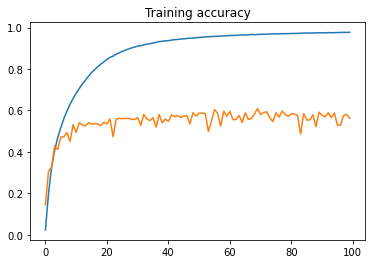

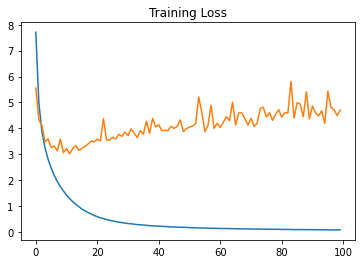

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg